# Phishing URL Detection


From Wikipedia, https://en.wikipedia.org/wiki/Phishing

> Phishing is the fraudulent attempt to obtain sensitive information such as usernames, passwords and credit card details, often for malicious reasons, by disguising as a trustworthy entity in an electronic communication. The word is a neologism created as a homophone of fishing due to the similarity of using a bait in an attempt to catch a victim. The annual worldwide impact of phishing could be as high as US$5 billion.
>
> Phishing is typically carried out by email spoofing or instant messaging, and it often directs users to enter personal information at a fake website, the look and feel of which are identical to the legitimate site, the only difference being the URL of the website in concern. Communications purporting to be from social web sites, auction sites, banks, online payment processors or IT administrators are often used to lure victims. Phishing emails may contain links to websites that distribute malware.
>
> Phishing is an example of social engineering techniques used to deceive users, and it exploits weaknesses in current web security. Attempts to deal with the growing number of reported phishing incidents include legislation, user training, public awareness, and technical security measures.

Here's an example of a real phishing email sent in 2011 by attackers looking to get login credentials for Facebook users:

<pre>
LAST WARNING : Your account is reported to have violated the policies that are considered annoying or insulting Facebook users.

Until we system will disable your account within 24 hours if you do not do the reconfirmation.

Please confirm your account below:

[ Link Removed ]

Thanks.
The Facebook Team
Copyright facebook © 2011 Inc. All rights reserved.
</pre>

A victim clicking on the Phishing link would be taken to a site that looked like a pretty good copy of the Facebook login screen.

<img src="images/Not_Facebook.png">

Here are some examples of the links used in emails sent by the attackers running this phishing campaign:

**Note**: These links may be dangerous to your computer. Our practice will be to "neuter" links by wrapping certain characters with square brackets so that you cannot click on these links, or accidentally copy/paste them into your browser.

**CAUTION: DO NOT CLICK ON OR VISIT THESE LINKS!!**
<pre>
http[:]//team-welcome[.]at[.]ua/facebook-support[.]html
http[:]//reportedpages[.]at[.]ua/facebook-support-account[.]html
http[:]//www[.]facebooks[.]cloud/PayPlls[.]CEanada[.]tNZnZZlR3ZdyZZ-5RkZZDRTZZBy
http[:]//www[.]greenaura[.]net/appz[.]westpac/westpac[.]appz/login[.]php
http[:]//www[.]irastrum[.]com/wp-admin/mail[.]yahoo[.]com/
http[:]//appleid[.]apple[.]com-subscriptions[.]manager508158125[.]kevinfoley[.]com
</pre>
**CAUTION: DO NOT CLICK ON OR VISIT THESE LINKS!!**


Something smells a little phishy about these links. Given a close look by a human, you'd probably be able to decide pretty quickly if the link was really sent by Facebook or not. But billions of people get hundreds or thousands of emails each every day! How can defenders keep up with the onslaught by the phishers?

## The Problem

We want to use methods from Machine Learning to build a computer program that will automatically flag links it thinks are phishing attempts. We can do this by studying the problem, looking at data, and learning a decision rule.

The dataset we will be using is named "FIU_Phishing_Mitre_Dataset.csv" and a testing dataset (without labels) is named "Test_FIU_Phishing_Mitre_Dataset.csv".
#### Analyze the data, build features, or use the existing features in the data to build a model, and report your findings. We will use the F1 score to evaluate the final models from participants using a test set that we have set aside. 



## Explore Some Data

Let's take a look at the provided features on our set of URLs. 

* Create Age (in Months): The age of the domain. If the value is -1, that information is not available or the domain has been deleted. 
* Expiry Age (in Months): The amount of months until the domain expires. If the value is negative, that information is not available or the domain has been deleted.
* Update Age (in Days): The last time the domain was updated. If the value is -1, that information is not available or the domain was deleted.
* URL: The URL of the website. Three periods have been added to the end of each URL to prevent the URL from being clicked for security purposes. 
* Label: A label to determine whether a website is a phishing link or not. 0 denotes a website that is not a phishing link, 1 denotes a website is a phishing link. 

In [44]:
from __future__ import print_function
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
#import Evaluation metrics 
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('FIU_Phishing_Mitre_Dataset.csv')

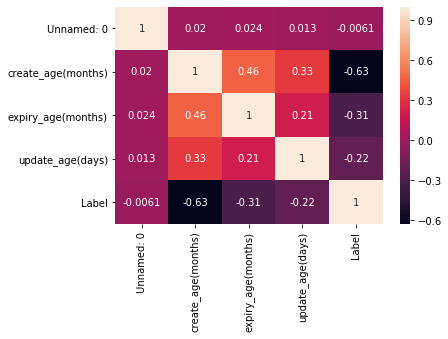

In [2]:
sns.heatmap(dataset.corr(),annot=True)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 6 columns):
Unnamed: 0            4799 non-null int64
create_age(months)    4799 non-null int64
expiry_age(months)    4799 non-null int64
update_age(days)      4799 non-null int64
URL                   4799 non-null object
Label                 4799 non-null int64
dtypes: int64(5), object(1)
memory usage: 225.0+ KB


In [4]:

def preprocess_dataset(dataset):
    dataset['url_length'] = dataset['URL'].apply(len)
    splited_data = dataset['URL'].str.split("://", n = 1, expand = True) 
    dataset['protocol'] = splited_data[0]
    dataset['hostname'] = splited_data[1].str.split("/", n = 1, expand = True)[0]

    def issubdomainwww(x):
        if x == 'www':
            return 1
        return 0

    dataset['thirdleveldomain'] = splited_data[1].str.split(".", n = 3, expand = True)[0].apply(issubdomainwww)

    def has_http_https(x):
        if x == 'http':
            return 1
        if x == 'https':
            return 1
        return 0
    dataset['protocol'] = dataset['protocol'].apply(has_http_https)
    from tld import get_tld

    def get_tld_from_dataframe(x):
        try:
            res = get_tld(x, as_object=True)
            if res is None:
                return 0
            if res.tld is None:
                return 0
        except:
            return 0
        return 1

    dataset['isvalid_tld']=dataset['URL'].apply(get_tld_from_dataframe)
    
    return dataset

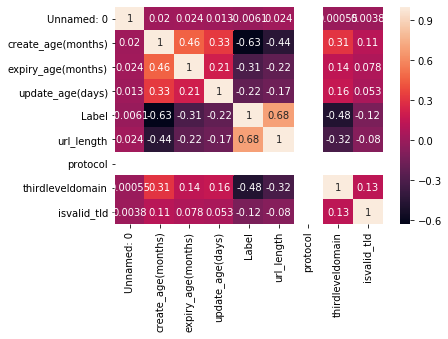

In [5]:
preprocess_dataset(dataset)

sns.heatmap(dataset.corr(),annot=True)

In [6]:
dataset

,Unnamed: 0,create_age(months),expiry_age(months),update_age(days),URL,Label,url_length,protocol,hostname,thirdleveldomain,isvalid_tld
0,642,-1,-1,-1,http://account-google-com.ngate.my/c44cca40176...,1,70,1,account-google-com.ngate.my,0,1
1,2968,212,16,663,http://www.coffeespecialties.com/...,0,36,1,www.coffeespecialties.com,1,1
2,2401,-1,-1,-1,http://black.pk/wp-content/2013/04/bp.postale/...,1,73,1,black.pk,0,1
3,5337,198,6,186,http://atomicsoda.com/manutd...,0,31,1,atomicsoda.com,0,1
4,6538,240,24,1684,http://bostoncoffeecake.com/...,0,31,1,bostoncoffeecake.com,0,1
5,2813,-1,-1,-1,http://www.durst.de/...,0,23,1,www.durst.de,1,1
6,5311,98,10,57,http://www.jobofmine.com/...,0,28,1,www.jobofmine.com,1,1
7,5304,2,10,61,http://safetem.com/fcid/login.php?cmd=login_su...,1,73,1,safetem.com,0,1
8,1252,21,3,280,http://elicafe.com/...,1,22,1,elicafe.com,0,1
9,4109,-1,-1,-1,http://www.vgl.ucdavis.edu/informatics/strand....,0,52,1,www.vgl.ucdavis.edu,1,1


In [32]:
x_dataset = dataset[['create_age(months)','update_age(days)','expiry_age(months)','url_length','thirdleveldomain','isvalid_tld']]
y_dataset = dataset[['Label']]

In [33]:

X_train,X_test,y_train,y_test=train_test_split(x_dataset,y_dataset,test_size=0.20,random_state=10)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3839 samples.
Testing set has 960 samples.


In [40]:

#create logistic regression object
Classifier=LogisticRegression(random_state= 5, multi_class='multinomial' , solver='newton-cg')
 
#Train the model using training data 
Classifier.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=5, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

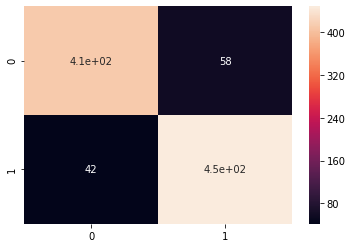

In [41]:

#Test the model using testing data
predictions = Classifier.predict(X_test)
cm=confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True)

In [42]:
print("f1 score is ",f1_score(y_test,predictions,average='weighted'))
print("The accuracy of your Logistic Regression on testing data is: ",100.0 *accuracy_score(y_test,predictions))

f1 score is  0.895768137485005
The accuracy of your Logistic Regression on testing data is:  89.58333333333334


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


accuracy score 0.915625
f1 score is  0.9155937479294274


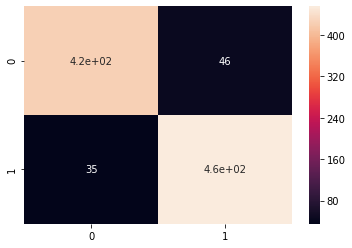

In [51]:
clf = KNeighborsClassifier(n_neighbors=5,weights='uniform',p=1)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)


print("accuracy score",accuracy_score(y_test,predictions))
cm=confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True)
print("f1 score is ",f1_score(y_test,predictions,average='weighted'))

# Testing

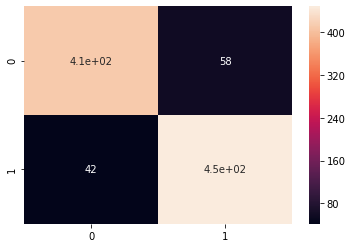

In [25]:
testdataset = pd.read_csv('tesx file name')
preprocess_dataset(testdataset)

x_dataset = testdataset[['create_age(months)','url_length','update_age(days)','expiry_age(months)','thirdleveldomain','isvalid_tld']]
y_dataset = testdataset[['Label']]

#import Evaluation metrics 
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report

#Test the model using testing data
predictions = Classifier.predict(X_test)
cm=confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True)

In [26]:
print("f1 score is ",f1_score(y_test,predictions,average='weighted'))
print("The accuracy of your Logistic Regression on testing data is: ",100.0 *accuracy_score(y_test,predictions))

f1 score is  0.895768137485005
The accuracy of your Logistic Regression on testing data is:  89.58333333333334
